## Loading Data via Zarr Endpoints

* Zarr Format Benefits:

    * Scalable, flexible
    * Easy to access via HTTP/HTTPS in cloud storage

* But:

    * Majority of datasets in HDF5 (netCDF4)
    * HDF5/netCDF4 hard to access via HTTP/HTTPS in cloud storage

* Freva Solution:

    * REST API streams any file format as Zarr
    * Zarr protocol endpoints accessible via any Zarr library

### Workflow
* Search netCDF4 datasets using Freva-REST API
* Access data through Zarr endpoints

Let's define the search parameters for the Freva-REST API and import what we need

In [24]:
search_params = {"file": "/home/*", "project": "cmip6"} # Define our search parameters
url = "http://localhost:7777" # URL of our test server.
from getpass import getpass
import requests
import xarray as xr

If we normally search for data we will get the locations of the netCDF files on the hard-drive:

In [22]:
list(requests.get(
    f"{url}/api/databrowser/data_search/freva/file", 
    params=search_params, 
    stream=True
).iter_lines(decode_unicode=True))

['/home/wilfred/workspace/databrowser/freva-rest/src/databrowser_api/tests/mock/data/model/global/cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/amip/r2i1p1f1/Amon/ua/gn/v20190815/ua_mon_MPI-ESM1-2-LR_amip_r2i1p1f1_gn_197901-199812.nc',
 '/home/wilfred/workspace/databrowser/freva-rest/src/databrowser_api/tests/mock/data/model/global/cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/amip/r1i1p1f1/Amon/ua/gn/v20201108/ua_Amon_ACCESS-CM2_amip_r1i1p1f1_gn_197901-201412.nc']

What if the data location is not directly accessible, because it's stored somewhere else, like on tape? 
 * We can use the `load` endpoint to stream stream the data as Zarr data.

**Caveat**: Because the data can be accessed from anywhere once it is made available via zarr we need to create an *access token*:

In [28]:
auth = requests.post(
    f"{url}/api/auth/v2/token",
    data={"username": "janedoe", "password":getpass("Password:")}
).json()

Password: ········


### "Order" the zarr datasets.
With this access token we can generate zarr enpoints to stream the data from anywhere, to do so we simply search for the datasets again:

In [29]:
res = requests.get(
    f"{url}/api/databrowser/load/freva", 
    params=search_params, 
    headers={
        "Authorization": f"Bearer {auth['access_token']
    }"},
    stream=True
)

This will search for data and for every found entry create a zarr endpoint that can be loaded:

In [30]:
zarr_files = list(res.iter_lines(decode_unicode=True))
zarr_files

['http://localhost:7777/api/freva-data-portal/zarr/16ac2b17-6a0d-551e-9b1c-abcbfc41f4dd.zarr',
 'http://localhost:7777/api/freva-data-portal/zarr/e39716b7-abde-56f7-8cde-4e9d9f2e4ea8.zarr']

### Open the zarr datasets

Let's load the data with xarray and zarr:

In [32]:
dset = xr.open_dataset(
    zarr_files[0],
    engine="zarr",
    chunks="auto", 
    storage_options={"headers": {"Authorization": f"Bearer {auth['access_token']}"}}
)
dset

<xarray.Dataset>
Dimensions:    (lat: 27, bnds: 2, lon: 43, plev: 19, time: 11)
Coordinates:
  * lat        (lat) float64 0.9326 2.798 4.663 6.528 ... 43.83 45.7 47.56 49.43
  * lon        (lon) float64 101.2 103.1 105.0 106.9 ... 174.4 176.2 178.1 180.0
  * plev       (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
  * time       (time) datetime64[ns] 1979-01-16T12:00:00 ... 1979-11-16
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(27, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(43, 2), meta=np.ndarray>
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(11, 2), meta=np.ndarray>
    ua         (time, plev, lat, lon) float32 dask.array<chunksize=(11, 19, 27, 43), meta=np.ndarray>
Attributes: (12/47)
    CDI:                   Climate Data Interface version 2.0.6 (https://mpim...
    source:                MPI-ESM1.2-LR (2017): \naerosol: none, prescribed ...
    institution:           Max Planck Institute for Meteorology, Hamburg 2014...
    Conventions:           CF-1.7 CMIP-6.2
    activity_id:           CMIP
    branch_method:         no parent
    ...                    ...
    variable_id:           ua
    variant_label:         r2i1p1f1
    license:               CMIP6 model data produced by MPI-M is licensed und...
    cmor_version:          3.5.0
    tracking_id:           hdl:21.14100/0898c2ad-5382-4d0c-8adb-2ca96387fb54
    CDO:                   Climate Data Operators version 2.0.6 (https://mpim...

We do have a xarray dataset, meaning we can just proceed with our analysis:

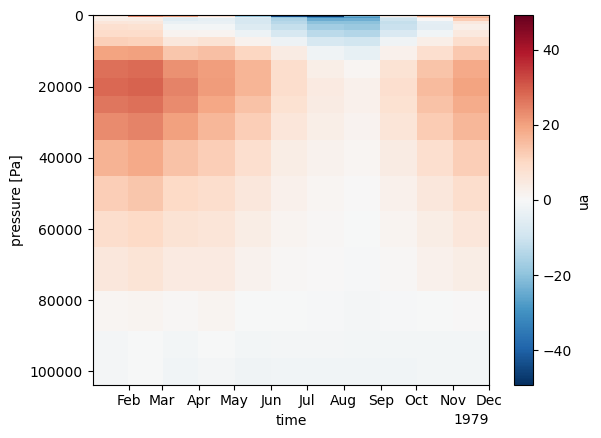

In [33]:
dset["ua"].mean(dim=("lon", "lat")).plot(x="time",  yincrease=False)

## How does it work?
<img src="outline.jpg" alt="image" width="50%">

## What's next?
- Add json payload to `load` endpoint that allows the users to pre-precess data. For example select a region by uploading a geojson shape file.
- Implement a backend handle to open tape archives